In [1]:
import faulthandler
faulthandler.enable()
from IPython.display import clear_output
from datetime import datetime
from matplotlib import cm
from cycler import cycler
import copy

import os
from os.path import join as opj

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
default_colors_ = tuple(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import delensalot
from delensalot.utils import cli
from delensalot.run import run
from delensalot.config.config_helper import load_config
from delensalot.utility.plot_helper import bandpass_alms, movavg
from delensalot.utility.utils_hp import Alm, almxfl, alm2cl, alm_copy

def dprint(dictionary, depth=0, max_depth=2):
    if isinstance(dictionary, dict):
        max_key_length = max(len(str(key)) for key in dictionary)  # Get longest key length
        for key, value in dictionary.items():
            # Add a tab for each depth level
            indent = '\t' * depth
            # If the value is a dictionary and the current depth is less than max_depth, recurse
            if isinstance(value, dict) and depth < max_depth:
                print(f"{indent}{key.ljust(max_key_length)} : ")
                dprint(value, depth + 1, max_depth)  # Recursively print the nested dictionary
            else:
                print(f"{indent}{key.ljust(max_key_length)} : {value}")
    else:
        print(dictionary)

def filter_secondary_and_component(dct, allowed_chars):
    dct = copy.deepcopy(dct)
    forbidden_chars_in_sec = 'teb'  # NOTE this filters the last part in case of non-symmetrized keys (e.g. 'pee')
    allowed_set = set("".join(c for c in allowed_chars if c not in forbidden_chars_in_sec))
    sec_to_remove = []
    for key, value in dct.items():
        if 'component' in value:
            value['component'] = [char for char in value['component'] if char in allowed_set]
            if not value['component']:
                sec_to_remove.append(key)
    for key in sec_to_remove:
        del dct[key]
    return dct

simulationdata_template = {
    'lensing': {
        'component': ['p','w'],
        'space': 'cl',},
    'birefringence': {
        'component': ['f'],
        'space': 'cl',
    }
  }
sim_sec = ['p_p','pw_p', 'pf_p', 'pwf_p']
rec_sec = ['p_p', 'pw_p', 'pf_p', 'pwf_p']
sec = filter_secondary_and_component(simulationdata_template, 'p_p')

planck_cmap = ListedColormap(np.loadtxt(os.path.dirname(delensalot.__file__)+"/data/Planck_Parchment_RGB.txt")/255.)
planck_cmap.set_bad("gray")
planck_cmap.set_under("white") 

fn = opj(os.getcwd(), 'config/conf_v3.py')
config = load_config(fn, 'configfile')

mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
setting defaults


## Run stuff

In [ ]:
job_id = 'MAP_lensrec'
delensalot_runner = run(config=config, job_id=job_id, verbose=False)
delensalot_runner.run()

## Load stuff

In [2]:
job_id = 'MAP_lensrec'
delensalot_runner = run(config=config, job_id=job_id, verbose=True)
clear_output(wait=True)
ana = delensalot_runner.collect_model()

simcomps = ana.data_container.cls_lib.seccomp
simin = ",".join([sc[0] for key, val in simcomps.items() for sc in val])
reccomps = ",".join([x for y in ana.QE_searchs for x in y.secondary.component])
translatetable = str.maketrans({"p": r"\phi", "w": r"\omega", "f": r"\beta"})

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

its = [0] if job_id in ('QE_lensrec') else np.arange(0, ana.maxiterdone()+1, 1)

sec_fids = ana.data_container.get_fidsec(0, return_nonrec=True)
sec_ins = ana.data_container.get_sim_sec(0, space='alm', return_nonrec=True)
secest = ana.get_est(idx=0, it=its, scale='k')

ana.Lmin = config.analysis.Lmin

ana.maxiterdone(), "/".join(ana.MAP_minimizers[0].libdir.rsplit('/',3)[1:])

Cell finished 17:08:44


(5, 'align3_lminB200simdata__lensing_p_w_birefringence_f/MAP/pwf_p')

In [ ]:
simin, reccomps

('p,w,f', 'p,w,f')

## check

Text(0, 0.5, '$C_L^{\\kappa\\kappa}$')

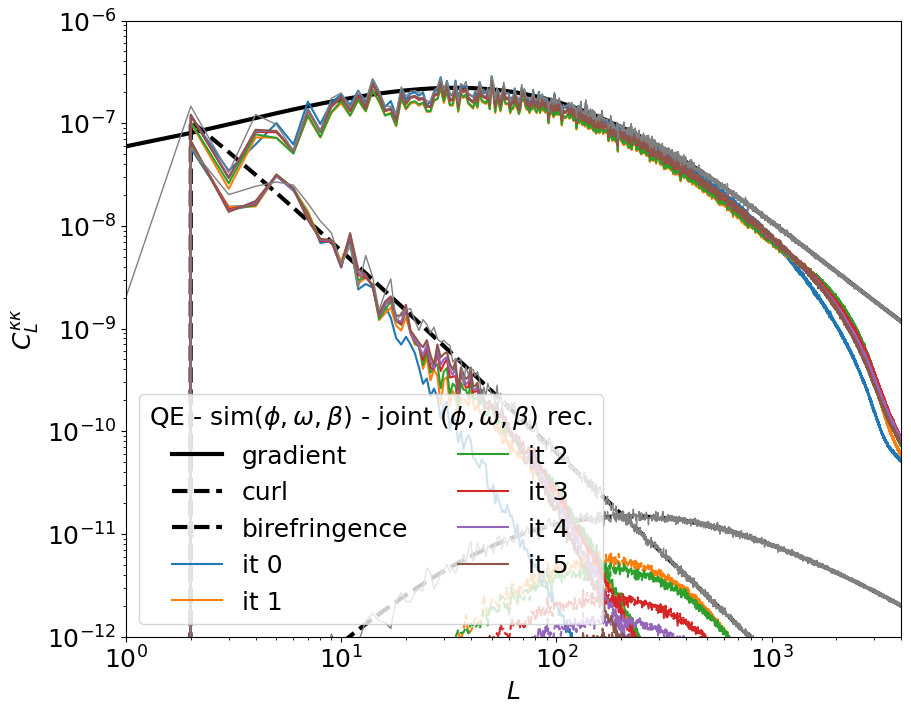

In [4]:
if job_id == 'MAP_lensrec': LM_max = ana.MAP_minimizers[0].likelihood.gradient_lib.subs[0].LM_max
elif job_id == 'QE_lensrec': LM_max = ana.MAP_minimizers[0].likelihood.gradient_lib.subs[0].LM_max

repeated_colors = [color for color in default_colors_ for _ in range(len(reccomps.split(',')))]
plt.rcParams['axes.prop_cycle'] = cycler(color=repeated_colors)

fig = plt.figure(figsize=(10,8))
LL = np.arange(LM_max[0]+1)
scale_factor_L = (LL*(LL+1))**2/4


plt.plot(scale_factor_L*sec_fids[0][0,:LM_max[0]+1], color='black',lw=3, ls='-', label='gradient')
if len(sec_fids[0])>1: plt.plot(scale_factor_L*sec_fids[0][1,:LM_max[0]+1], color='black',lw=3, ls='--', label='curl')
if len(sec_fids)>1: plt.plot(sec_fids[1][0,:LM_max[0]+1], color='black',lw=3, ls='--', label='birefringence')

for seciti, secit in enumerate(secest):
    # if seciti == 0:
        for seci, sec in enumerate(secit):
            # if seci == 0:
                for compi, comp in enumerate(sec):
                    st = '' if seci==0 and compi==0 else "_" # and compi==0 else "_"
                    p = plt.plot(hp.alm2cl(comp), label=st+f"it {its[seciti]}", ls='-' if compi==0 else '--')

plt.plot(scale_factor_L*hp.alm2cl(sec_ins[0][0])[:LM_max[0]+1], color='grey', lw=1)
if len(sec_ins[0])>1:plt.plot(scale_factor_L*hp.alm2cl(sec_ins[0][1])[:LM_max[0]+1], color='grey', lw=1)
if len(sec_ins)>1:plt.plot(hp.alm2cl(sec_ins[1][0])[:LM_max[0]+1], color='grey', lw=1)


plt.ylim(1e-12,1e-6)
plt.xlim(np.min(list(ana.Lmin.values())),4e3)
plt.loglog()
plt.legend(title=rf'QE - sim(${simin.translate(str.maketrans(translatetable))}$) - joint (${reccomps.translate(str.maketrans(translatetable))})$ rec.', ncol=2, loc='lower left')
plt.xlabel(r'$L$')
plt.ylabel(r'$C_L^{\kappa\kappa}$')

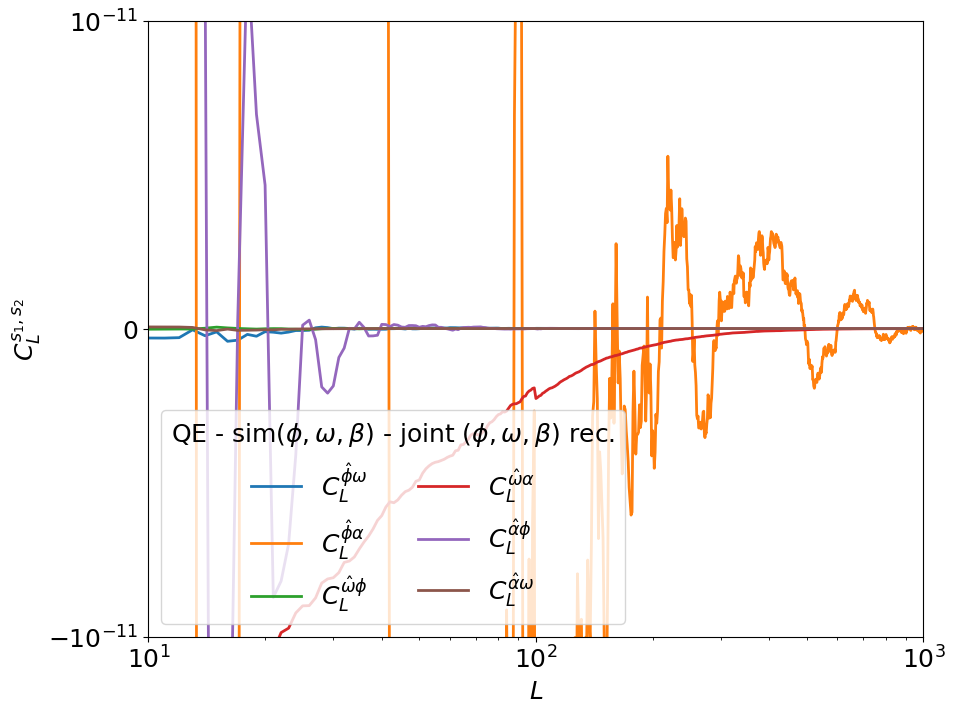

In [5]:
fig = plt.figure(figsize=(10,8))
repeated_colors = [color for color in default_colors_ for _ in range(len(reccomps.split(',')))]
plt.rcParams['axes.prop_cycle'] = cycler(color=default_colors_[:6])

mvg = 20
if len(sec_ins)>1: bire_in = alm_copy(sec_ins[1][0], None, hp.Alm.getlmax(sec_ins[0][0].size),hp.Alm.getlmax(sec_ins[0][0].size))
idx2seccomp = {(0,0): r'\hat{\phi}',
               (0,1): r'\hat{\omega}',
               (1,0): r'\hat{\alpha}',}
idx2seccompin = {(0,0): r'\phi',
               (0,1): r'\omega',
               (1,0): r'\alpha',}
for seciti, secit in enumerate(secest):
    if seciti == ana.maxiterdone():# or seciti == 0:
        if seciti == 0:
            alpha = 0.2
            lw = 5
            ls = '--'
        else:
            alpha = 1
            lw = 2
            ls = '-'
        for seci, sec in enumerate(secit):
            for compi, comp in enumerate(sec):
                for seci_,  sec_ in enumerate(sec_ins):
                    for compi_, ins_ in enumerate(sec_):
                        if compi == compi_ and seci == seci_:
                            continue
                        ins = alm_copy(ins_, None, hp.Alm.getlmax(comp.size), hp.Alm.getlmax(comp.size))
                        st = '_' if seciti==0 else "" # 
                        # st=''
                        label = st+fr"$C_L^{{{idx2seccomp[(seci,compi)]}{idx2seccompin[(seci_,compi_)]}}}$"     
                        plt.plot(movavg(hp.alm2cl(comp,ins),mvg), label=label, alpha=alpha, lw=lw, ls=ls)

plt.legend(title=rf'QE - sim(${simin.translate(str.maketrans(translatetable))}$) - joint (${reccomps.translate(str.maketrans(translatetable))})$ rec.', ncol=2, loc='lower left')
plt.xscale('log')
plt.ylabel(r'$C_L^{s_1,s_2}$')
plt.xlabel(r'$L$')
plt.xlim(10,1000)
plt.ylim(-1e-11,1e-11)
plt.yscale('symlog')    
# plt.loglog()

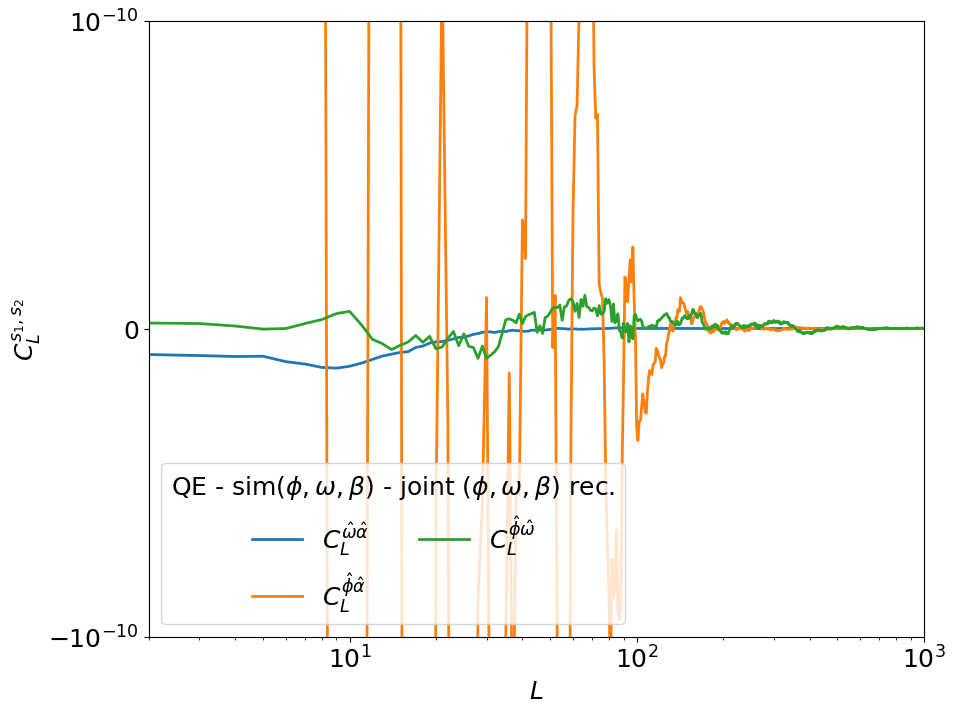

In [6]:
fig = plt.figure(figsize=(10,8))
repeated_colors = [color for color in default_colors_ for _ in range(len(reccomps.split(',')))]
plt.rcParams['axes.prop_cycle'] = cycler(color=default_colors_[:6])

mvg = 10
if len(sec_ins)>1: bire_in = alm_copy(sec_ins[1][0], None, hp.Alm.getlmax(sec_ins[0][0].size),hp.Alm.getlmax(sec_ins[0][0].size))
idx2seccomp = {(0,0): r'\hat{\phi}',
               (0,1): r'\hat{\omega}',
               (1,0): r'\hat{\alpha}',}
idx2seccompin = {(0,0): r'\hat{\phi}',
               (0,1): r'\hat{\omega}',
               (1,0): r'\hat{\alpha}',}

from itertools import combinations
secondaries = [0, 1]
components = {0: [0, 1], 1: [0]}
all_components = [(sec, comp) for sec in secondaries for comp in components[sec]]
unique_pairs = set(tuple(sorted(pair)) for pair in combinations(all_components, 2))


for seciti, secit in enumerate(secest):
    if seciti == ana.maxiterdone():# or seciti == 0:
        if seciti == 0:
            alpha = 0.2
            lw = 5
            ls = '--'
        else:
            alpha = 1
            lw = 2
            ls = '-'
        for pair in unique_pairs:
            st = '_' if seciti==0 else "" # 
            label = st+fr"$C_L^{{{idx2seccomp[(pair[0][0],pair[0][1])]}{idx2seccompin[(pair[1][0],pair[1][1])]}}}$"     
            plt.plot(movavg(hp.alm2cl(secit[pair[0][0]][pair[0][1]],secit[pair[1][0]][pair[1][1]]),mvg), label=label, alpha=alpha, lw=lw, ls=ls)

plt.legend(title=rf'QE - sim(${simin.translate(str.maketrans(translatetable))}$) - joint (${reccomps.translate(str.maketrans(translatetable))})$ rec.', ncol=2, loc='lower left')
plt.xscale('log')
plt.ylabel(r'$C_L^{s_1,s_2}$')
plt.xlabel(r'$L$')
plt.xlim(2,1000)
plt.ylim(-1e-10,1e-10)
plt.yscale('symlog')    
# plt.loglog()

/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_43379/3829330670.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(movavg((hp.alm2cl(comp, secin)/np.sqrt((hp.alm2cl(comp, comp))*(hp.alm2cl(secin, secin)))),mvg), label=st+f'it {seciti}',lw=lw, alpha=alpha)


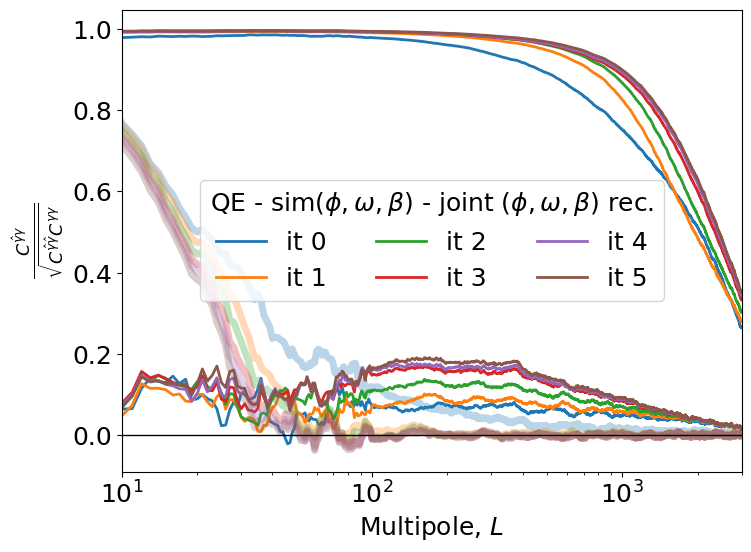

In [7]:
repeated_colors = [color for color in default_colors_ for _ in range(len(reccomps.split(',')))]
plt.rcParams['axes.prop_cycle'] = cycler(color=repeated_colors)
fig = plt.figure(figsize=(8,6))
def minzero(x):
    return np.maximum(x,1e-15)
mvg = 10

for seciti, secit in enumerate(secest):
    for seci, sec in enumerate(secit):
        for compi, comp in enumerate(sec):
            st = '' if seci==0 and compi==0 else "_"
            if seci in [0,1]:
                if seci == 1:
                    alpha=0.3
                    lw=5
                else:
                    alpha=1
                    lw=2
                # if seciti == 1:
                # if seci == 0 and compi == 0:
                if len(sec_ins) > seci and len(sec_ins[seci]) > compi:
                    secin = alm_copy(sec_ins[seci][compi], None, Alm.getlmax(comp.size, None),Alm.getlmax(comp.size, None))
                    # plt.plot(hp.alm2cl(comp, secin))#, label=st+f"it {its[seciti]}")
                    # plt.plot((hp.alm2cl(comp, secin)/np.sqrt((hp.alm2cl(comp, comp))*(hp.alm2cl(secin, secin)))), label=st+f'{seciti}')
                    plt.plot(movavg((hp.alm2cl(comp, secin)/np.sqrt((hp.alm2cl(comp, comp))*(hp.alm2cl(secin, secin)))),mvg), label=st+f'it {seciti}',lw=lw, alpha=alpha)  

plt.xlim(mvg,3000)
simcomps = ana.data_container.cls_lib.seccomp
simin = ",".join([sc[0] for key, val in simcomps.items() for sc in val])
reccomps = ",".join([x for y in ana.QE_searchs for x in y.secondary.component])
translatetable = str.maketrans({"p": r"\phi", "w": r"\omega", "f": r"\beta"})
plt.legend(title=rf'QE - sim(${simin.translate(str.maketrans(translatetable))}$) - joint (${reccomps.translate(str.maketrans(translatetable))})$ rec.', ncol=3)#, loc='upper left')

plt.xlabel(r'Multipole, $L$')
plt.ylabel(r'$\frac{C^{\hat{\gamma}\gamma}}{\sqrt{C^{\hat{\gamma}\hat{\gamma}}C^{\gamma\gamma}}}$')
# plt.yscale('log')
plt.hlines(0,0,3000, color='black', lw=1)
plt.xscale('log')

## delete

In [ ]:
simidx = 0
its = [1,2,3,4]
for it in its:
    op = 1
    ana.MAP_searchs[simidx].secondaries['lensing'].remove(0,it)
    ana.MAP_searchs[simidx].secondaries['birefringence'].remove(0,it)
    ana.MAP_searchs[simidx].curvature.field.remove(0,it)
    ana.MAP_searchs[simidx].gradients[op].gfield.remove(0, it)
    ana.MAP_searchs[simidx].ivf_filter.ivf_field.remove(0,it)
    ana.MAP_searchs[simidx].wf_filter.wf_field.remove(0,it+1)
    # pass

cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove
cannot find field to remove


## maps

In [ ]:
ll = np.arange(LM_max[0]+1)
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(secest[-1][0][0],cli(np.sqrt(ll*(ll+1)))),5,300),nside=256), cmap='YlGnBu')#, min=-2e-3, max=2e-3)
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(sec_ins[0][0],np.sqrt(ll*(ll+1))),5,300),nside=256), cmap='YlGnBu')#, min=-2e-3, max=2e-3)
hp.mollview(hp.alm2map(bandpass_alms(alm_copy(hp.almxfl(sec_ins[0][0],np.sqrt(ll*(ll+1))),None,4000,4000) - hp.almxfl(secest[-1][0][0],cli(np.sqrt(ll*(ll+1)))),5,300),nside=256), cmap='YlGnBu', min=-2e-3, max=2e-3)

In [ ]:
ll = np.arange(LM_max[0]+1)
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(secest[-1][0][1],cli(np.sqrt(ll*(ll+1)))),1,20),nside=256), cmap='YlGnBu', min=-1e-6, max=1e-6)
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(sec_ins[0][1],np.sqrt(ll*(ll+1))),1,20),nside=256), cmap='YlGnBu', min=-1e-6, max=1e-6)#, min=-2e-3, max=2e-3)
hp.mollview(hp.alm2map(bandpass_alms(alm_copy(hp.almxfl(sec_ins[0][1],np.sqrt(ll*(ll+1))),None,4000,4000) - hp.almxfl(secest[-1][0][1],cli(np.sqrt(ll*(ll+1)))),1,30),nside=256), cmap='YlGnBu')#, min=-2e-3, max=2e-3)

In [ ]:
ll = np.arange(LM_max[0]+1)
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(secest[-1][1][0],cli(np.sqrt(ll*(ll+1)))),100,300),nside=256), cmap='YlGnBu', min=-5e-6, max=5e-6)
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(sec_ins[1][0],np.sqrt(ll*(ll+1))),100,300),nside=256), cmap='YlGnBu')#, min=-1e-2, max=1e-2)
hp.mollview(hp.alm2map(bandpass_alms(alm_copy(hp.almxfl(sec_ins[1][0],np.sqrt(ll*(ll+1))),None,4000,4000) - hp.almxfl(secest[-1][1][0],cli(np.sqrt(ll*(ll+1)))),5,300),nside=256), cmap='YlGnBu')#, min=-2e-3, max=2e-3)

## gradients

In [8]:
its = np.arange(1, ana.maxiterdone()+1, 1)

quads = ana.get_gradient_quad(0,its)
totals = ana.get_gradient_total(0,its)
priors = ana.get_gradient_prior(0,its)


INFO:: 02-24 17:09:52:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for lensing
INFO:: 02-24 17:09:53:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for birefringence
INFO:: 02-24 17:09:53:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for lensing
INFO:: 02-24 17:09:53:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for birefringence
INFO:: 02-24 17:09:54:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for lensing
INFO:: 02-24 17:09:54:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for birefringence
INFO:: 02-24 17:09:55:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for lensing
INFO:: 02-24 17:09:55:: delensalot.core.MAP.gradient.get_gradient_total - calculating total gradient for birefringence
INFO:: 02-24 17:09:56:: delensalot.core.MAP.gradient.get_gradient_total 

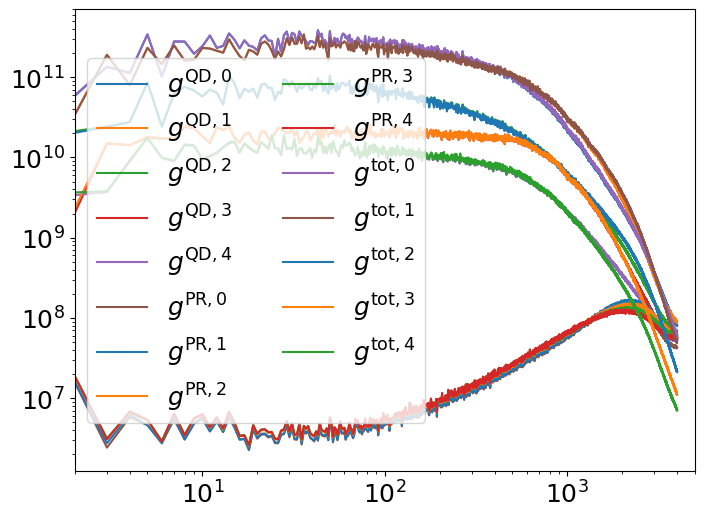

In [9]:
repeated_colors = [color for color in default_colors_ for _ in range(3)]
plt.rcParams['axes.prop_cycle'] = cycler(color=default_colors_[:6])#

fig = plt.figure(figsize=(8,6))
secidx, compidx = 0, 0

for it, quad in enumerate(quads):
    p = plt.plot(hp.alm2cl(quad[secidx][compidx]), label=fr"$g^{{\rm QD,{it}}}$")

for pi, prior in enumerate(priors):
    plt.plot(hp.alm2cl(prior[secidx][compidx]), label=fr"$g^{{\rm PR,{pi}}}$")

for pi, total in enumerate(totals):
    plt.plot(hp.alm2cl(total[secidx][compidx]), label=fr"$g^{{\rm tot,{pi}}}$")

plt.loglog()
plt.xlim(ana.Lmin['p'],5e3)
plt.legend(ncol=2)

# Templates

In [ ]:
lm_max_in, lm_max_out = (1000,1000), (1000,1000)
it = ana.maxiterdone()
template = ana.get_template(0, it=it, lm_max_out=lm_max_out)
templatelens = ana.get_template(0, it=it, secondary='lensing', lm_max_out=lm_max_out)
templatelensp = ana.get_template(0, it=it, secondary='lensing', component='p', lm_max_out=lm_max_out)
templatelensw = ana.get_template(0, it=it, secondary='lensing', component='w', lm_max_out=lm_max_out)
templatebirefringence = ana.get_template(0, it=it, secondary='birefringence', lm_max_out=lm_max_out)

In [7]:
simCMB = ana.data_container.get_sim_sky(0, space='alm', spin=0, field='polarization')
simCMB = np.array([alm_copy(_, None, *lm_max_out) for _ in simCMB])

DEBUG:: 02-24 17:02:12:: delensalot.sims.data_source.get_sim_sky - requestingsky_spacealm_spin0_fieldpolarization_0


(10.0, 200.0)

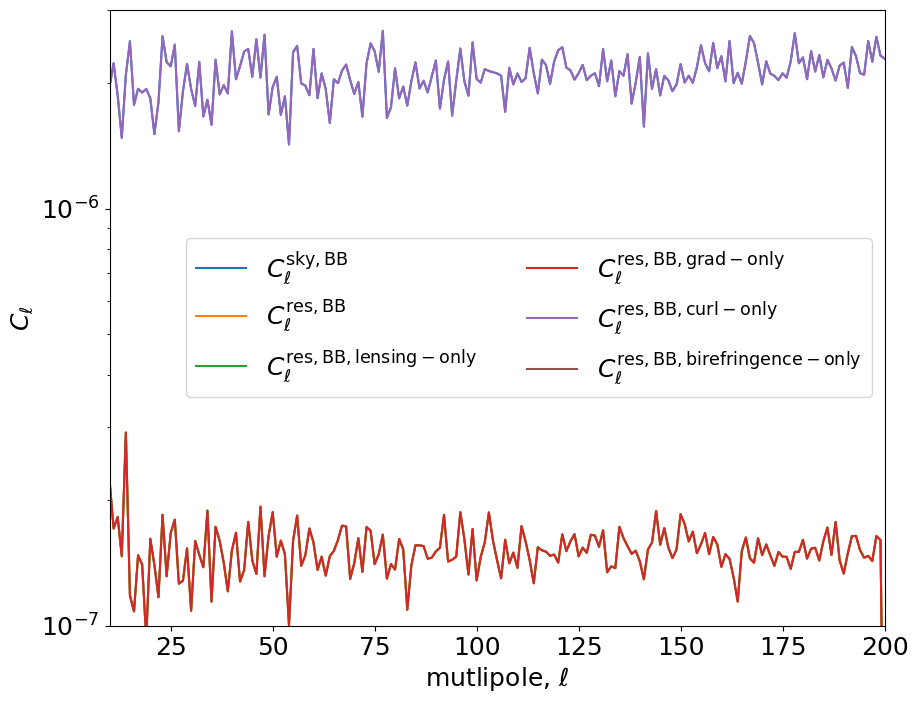

In [8]:
repeated_colors = [color for color in default_colors_ for _ in range(3)]
plt.rcParams['axes.prop_cycle'] = cycler(color=default_colors_)

fig = plt.figure(figsize=(10, 8))

plt.plot(hp.alm2cl(simCMB)[1], label=r"$C_\ell^{\rm sky,BB}$")
plt.plot(hp.alm2cl(simCMB-template)[1], label=r"$C_\ell^{\rm res,BB}$")
plt.plot(hp.alm2cl(simCMB-templatelens)[1], label=r"$C_\ell^{\rm res,BB,lensing-only}$")
plt.plot(hp.alm2cl(simCMB-templatelensp)[1], label=r"$C_\ell^{\rm res,BB,grad-only}$")
plt.plot(hp.alm2cl(simCMB-templatelensw)[1], label=r"$C_\ell^{\rm res,BB,curl-only}$")
plt.plot(hp.alm2cl(simCMB-templatebirefringence)[1], label=r"$C_\ell^{\rm res,BB,birefringence-only}$")

plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'mutlipole, $\ell$')
plt.ylim(1e-7,0.3e-5)
plt.legend(ncol=2)
plt.plot
plt.yscale('log')
plt.xlim(10,200)

/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_43099/563912818.py:8: RuntimeWarning: invalid value encountered in divide
  ax2.plot(hp.alm2cl((simCMB-template)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB}$")
/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_43099/563912818.py:9: RuntimeWarning: invalid value encountered in divide
  ax2.plot(hp.alm2cl((simCMB-templatelens)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB}$")
/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_43099/563912818.py:10: RuntimeWarning: invalid value encountered in divide
  ax2.plot(hp.alm2cl((simCMB-templatelensp)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB,grad-only}$")
/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_43099/563912818.py:11: RuntimeWarning: invalid value encountered in divide
  ax1.plot(hp.alm2cl((simCMB-templatelensw)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB,curl-only}$")
/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000

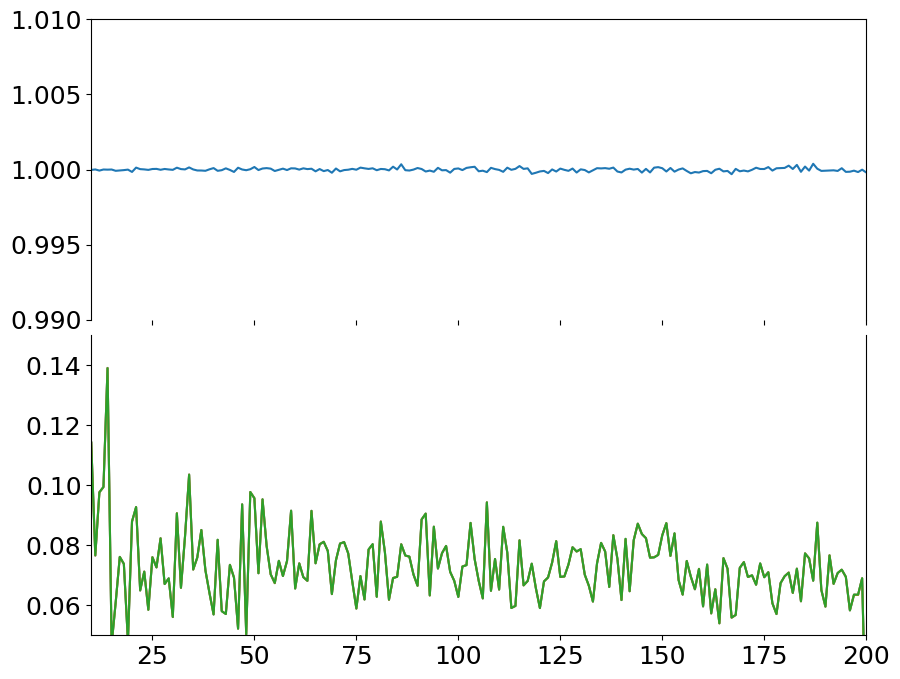

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})

# Plot the lower part
ax2.plot(hp.alm2cl((simCMB-template)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB}$")
ax2.plot(hp.alm2cl((simCMB-templatelens)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB}$")
ax2.plot(hp.alm2cl((simCMB-templatelensp)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB,grad-only}$")
ax1.plot(hp.alm2cl((simCMB-templatelensw)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB,curl-only}$")
ax1.plot(hp.alm2cl((simCMB-templatebirefringence)[1])/hp.alm2cl(simCMB[1]), label=r"$C_\ell^{\rm res,BB,birefringence-only}$")


# Remove the space between the y-ranges
ax1.set_ylim(0.99, 1.01)
ax2.set_ylim(0.05, 0.15)

ax1.set_xlim(10,200)
ax2.set_xlim(10,200)

# Hide spines between axes
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

In [10]:
Alens = [np.mean((hp.alm2cl(simCMB[1]-x[1])*cli(hp.alm2cl(simCMB[1])))[1:100]) for x in [template, templatelens, templatelensp, templatelensw, templatebirefringence]]
names = ['both', 'lensing', 'lensing-p', 'lensing-w', 'birefringence']
formatted_values = ",\n\t".join(f"\t{name}:\t{value:.5f}" for name, value in zip(names, Alens))

print("Residual B from template\n\t", formatted_values)

Residual B from template
	 	both:	0.07383,
		lensing:	0.07383,
		lensing-p:	0.07383,
		lensing-w:	0.98990,
		birefringence:	0.98990


# filters

In [11]:
its_wf = np.arange(0, ana.maxiterdone()+1, 1)
wfs = np.array([ana.get_wflm(0, it=it, lm_max=(4200,4200)) for it in its_wf])
print(wfs.shape)

its_ivfres = its_wf[1:]
ivfreslm = np.array([ana.get_ivfreslm(0, it=it) for it in its_ivfres])
print(ivfreslm.shape)

ivflm = np.array([ana.get_ivflm(0, it=it) for it in [0]])
print(ivflm.shape)

(6, 8826301)
(5, 2, 7225701)
(1, 2, 7225701)


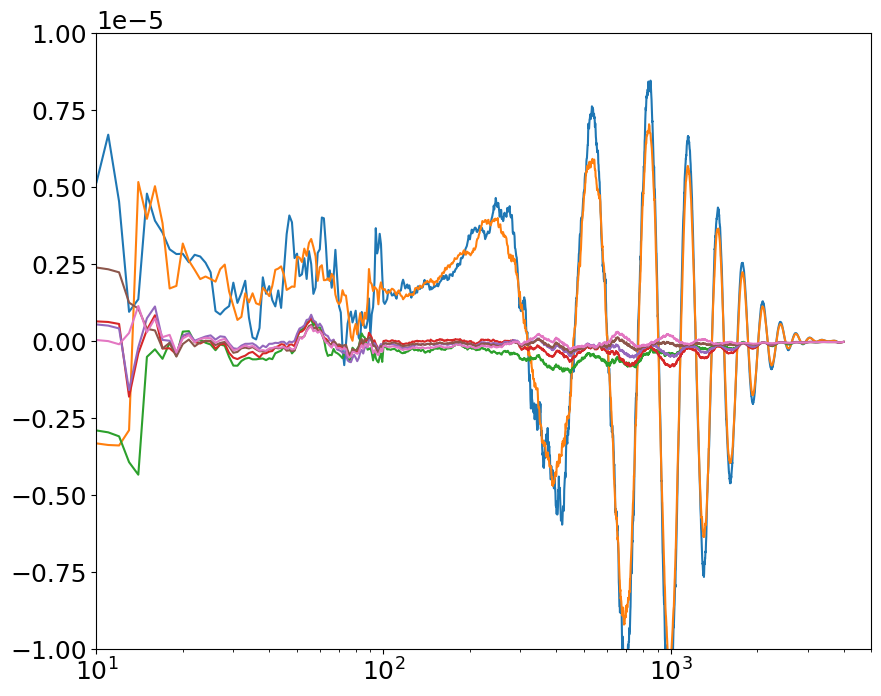

[]

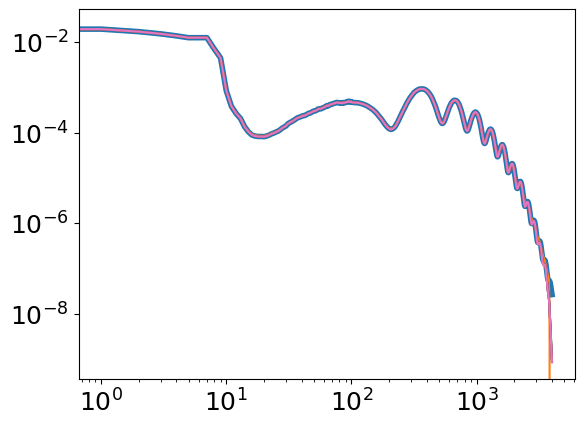

In [16]:
fig = plt.figure(figsize=(10, 8))

p = plt.plot(movavg(hp.alm2cl(wfs[0])[:4001]-hp.alm2cl(ana.data_container.get_sim_pri(0,field='polarization',space='alm',spin=0)[0])[:4001],10))
for iti, it in enumerate(its_wf):
    # if iti==12:
        p = plt.plot(movavg(hp.alm2cl(wfs[iti])[:4001]-hp.alm2cl(ana.data_container.get_sim_pri(0,field='polarization',space='alm',spin=0)[0])[:4001],20))
plt.xscale('log')
plt.ylim(-1e-5,1e-5)
plt.xlim(1e1,5e3)
plt.show()


p = plt.plot(movavg(hp.alm2cl(ana.data_container.get_sim_pri(0,field='polarization',space='alm',spin=0)[0])[:4001],10),lw=4)
for iti, it in enumerate(its_wf):
    p = plt.plot(movavg(hp.alm2cl(wfs[iti])[:4001],10))
plt.loglog()

DEBUG:: 02-24 17:05:27:: delensalot.sims.data_source.get_sim_sky - requestingsky_spacealm_spin0_fieldpolarization_0
DEBUG:: 02-24 17:05:28:: delensalot.sims.data_source.get_sim_sky - requestingsky_spacealm_spin0_fieldpolarization_0


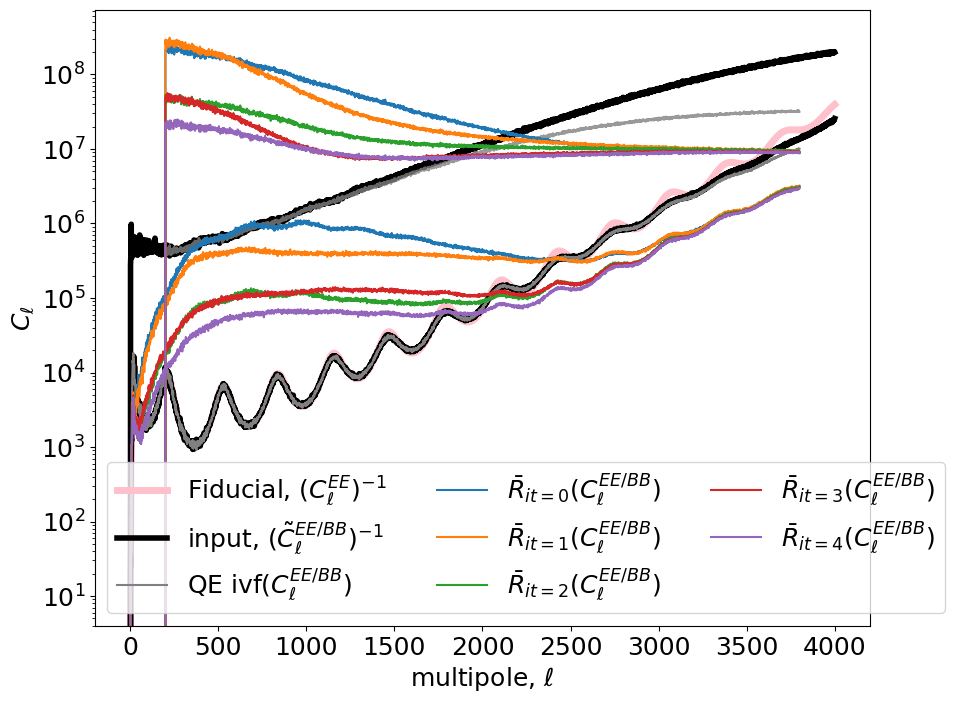

In [17]:
fig = plt.figure(figsize=(10,8))
repeated_colors = [color for color in default_colors_ for _ in range(2)]
plt.rcParams['axes.prop_cycle'] = cycler(color=repeated_colors)

ll = np.arange(4001)
scale_factor_l = (ll*(ll+1))**2/(2*np.pi)

plt.plot(cli(ana.data_container.get_fidCMB(0,'ee')[0,:4001]), label=r'Fiducial, $(C_{\ell}^{EE})^{-1}$', color='pink',lw=5)
plt.plot(cli(hp.alm2cl(ana.data_container.get_sim_sky(0,field='polarization',space='alm',spin=0))[0,:4001]), label=r'input, $(\tilde{C}_{\ell}^{EE/BB})^{-1}$', color='black', lw=4)
plt.plot(cli(hp.alm2cl(ana.data_container.get_sim_sky(0,field='polarization',space='alm',spin=0))[1,:4001]), color='black', lw=4)

for iti, it in enumerate([0]):
    p = plt.plot(hp.alm2cl(ivflm[0][0]), ls='-', label=r"QE ivf($C_\ell^{EE/BB}$)", color='grey', alpha=1.0)
    if len(ivflm[iti][0])>1: plt.plot(hp.alm2cl(ivflm[0,1]), ls='-', color='grey', alpha=0.8)

repeated_colors = [color for color in default_colors_ for _ in range(ana.maxiterdone())]
plt.rcParams['axes.prop_cycle'] = cycler(color=repeated_colors)

for iti, it in enumerate(its_ivfres):
        p = plt.plot(hp.alm2cl(ivfreslm[iti][0]), ls='-', label=fr"$\bar{{R}}_{{it={iti}}}(C_\ell^{{EE/BB}}$)")
        if len(ivfreslm[iti][0])>1: plt.plot(hp.alm2cl(ivfreslm[iti][1]), ls='-')


# ana.MAP_searchs[0].ivf_filter.beam.act(ivfreslm[iti],adjoint=True,lm_max=(4000,4000)))
# plt.loglog()
# plt.xlim(2e1,5e3)
plt.yscale('log')
plt.xlabel('multipole, $\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.legend(ncol=3)

DEBUG:: 02-24 16:00:27:: delensalot.sims.data_source.get_sim_sky - requestingsky_spacealm_spin0_fieldpolarization_0


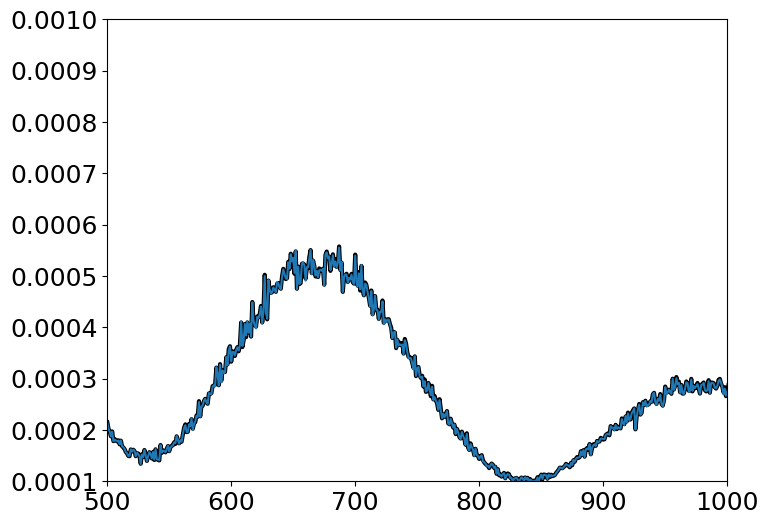

/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_40455/4008571358.py:16: RuntimeWarning: invalid value encountered in divide
  plt.plot(hp.alm2cl(CMBsky, CMBpri)/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(CMBpri)))
/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_40455/4008571358.py:19: RuntimeWarning: invalid value encountered in divide
  plt.plot(hp.alm2cl(CMBsky, wfs[-1])/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(wfs[-1])))
/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_40455/4008571358.py:21: RuntimeWarning: invalid value encountered in divide
  plt.plot(hp.alm2cl(CMBpri, wfs[0])/np.sqrt(hp.alm2cl(CMBpri)*hp.alm2cl(wfs[0])))
/var/folders/rj/y_xwp1w553xf8mbydr81ckt40000gn/T/ipykernel_40455/4008571358.py:23: RuntimeWarning: invalid value encountered in divide
  plt.plot(hp.alm2cl(CMBpri, wfs[-1])/np.sqrt(hp.alm2cl(CMBpri)*hp.alm2cl(wfs[-1])))


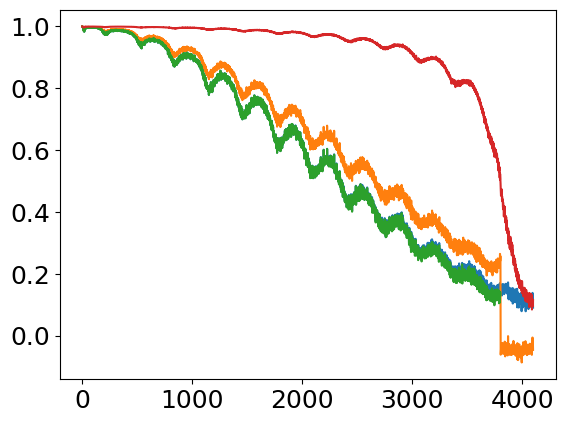

In [ ]:
fig = plt.figure(figsize=(8,6))
repeated_colors = [color for color in default_colors_ for _ in range(1)]
plt.rcParams['axes.prop_cycle'] = cycler(color=repeated_colors)

CMBpri = alm_copy(ana.data_container.get_sim_pri(0,field='polarization',space='alm',spin=0)[0],None,4200,4200)
CMBsky = alm_copy(ana.data_container.get_sim_sky(0,field='polarization',space='alm',spin=0)[0],None,4200,4200)
plt.plot(hp.alm2cl(CMBpri), lw=3, color='black')
# plt.plot(hp.alm2cl(wfs[0]))
plt.plot(hp.alm2cl(wfs[-1]))
plt.xlim(5e2,1e3)
plt.ylim(1e-4,1e-3)
# plt.loglog()
plt.show()


plt.plot(hp.alm2cl(CMBsky, CMBpri)/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(CMBpri)))
# plt.plot(hp.alm2cl(CMBsky, wfs[0])/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(wfs[0])))
# plt.plot(hp.alm2cl(CMBsky, wfs[1])/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(wfs[1])))
plt.plot(hp.alm2cl(CMBsky, wfs[-1])/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(wfs[-1])))

plt.plot(hp.alm2cl(CMBpri, wfs[0])/np.sqrt(hp.alm2cl(CMBpri)*hp.alm2cl(wfs[0])))
# plt.plot(hp.alm2cl(CMBpri, wfs[1])/np.sqrt(hp.alm2cl(CMBpri)*hp.alm2cl(wfs[1])))
plt.plot(hp.alm2cl(CMBpri, wfs[-1])/np.sqrt(hp.alm2cl(CMBpri)*hp.alm2cl(wfs[-1])))
# plt.plot(hp.alm2cl(CMBsky, wfs[1])/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(wfs[1])))
# plt.plot(hp.alm2cl(CMBsky, wfs[-1])/np.sqrt(hp.alm2cl(CMBsky)*hp.alm2cl(wfs[-1])))

In [ ]:
ana.simulationdata

<function delensalot.core.handler.MAPScheduler.__getattr__.<locals>.method_forwarder(idx, *args, **kwargs)>